In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime  
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import folium
from folium.plugins import HeatMap
from math import floor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix
from sqlalchemy import create_engine
from sqlalchemy import text
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import csv
from shapely.geometry import Point, Polygon
import time
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import dask.dataframe as dd
from sklearn.neighbors import KNeighborsClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
df = pd.read_csv("../Final_Weekday_Model_Data_NoWeather_Crime.csv")
df

,Unnamed: 0,longitude,latitude,Hour,Day of Week,Cluster,total_weekday_trips,Normalized_Score
0,0,-73.982155,40.767937,17,0,50,82.0,0.918367
1,1,-73.982185,40.768375,17,0,50,82.0,0.918367
2,2,-73.981796,40.768520,17,0,50,82.0,0.918367
3,3,-73.982414,40.768234,17,0,50,82.0,0.918367
4,4,-73.982101,40.768131,17,0,50,82.0,0.918367
...,...,...,...,...,...,...,...,...
867969,1171008,-73.995300,40.754719,5,2,426,3.0,0.000000
867970,1171009,-73.946228,40.821091,19,2,130,16.0,0.061224
867971,1171010,-74.004143,40.713058,3,4,406,2.0,0.000000
867972,1171011,-73.985336,40.736019,4,2,385,3.0,0.000000


In [3]:
df = df.drop(columns=["Unnamed: 0"])
df

,longitude,latitude,Hour,Day of Week,Cluster,total_weekday_trips,Normalized_Score
0,-73.982155,40.767937,17,0,50,82.0,0.918367
1,-73.982185,40.768375,17,0,50,82.0,0.918367
2,-73.981796,40.768520,17,0,50,82.0,0.918367
3,-73.982414,40.768234,17,0,50,82.0,0.918367
4,-73.982101,40.768131,17,0,50,82.0,0.918367
...,...,...,...,...,...,...,...
867969,-73.995300,40.754719,5,2,426,3.0,0.000000
867970,-73.946228,40.821091,19,2,130,16.0,0.061224
867971,-74.004143,40.713058,3,4,406,2.0,0.000000
867972,-73.985336,40.736019,4,2,385,3.0,0.000000


In [4]:
gdf = gpd.read_file('../Borough_Boundaries.geojson')
manhattan_boundary = gdf[gdf['boro_name'] == 'Manhattan']

In [5]:
bounding_box = manhattan_boundary.geometry.bounds

In [6]:
minx = bounding_box.minx.min()
maxx = bounding_box.maxx.max()
miny = bounding_box.miny.min()
maxy = bounding_box.maxy.max()

In [16]:
dx = 15 / 85000  # 15m in longitude degrees
dy = 15 / 111000  # 15m in latitude degrees

In [17]:
nx = int(np.ceil((maxx - minx) / dx))
ny = int(np.ceil((maxy - miny) / dy))

In [18]:
polygons = []

In [19]:
polygons = []
for i in range(ny):
    for j in range(nx):
        polygon = Polygon([
            (minx + j*dx, miny + i*dy),
            (minx + (j+1)*dx, miny + i*dy),
            (minx + (j+1)*dx, miny + (i+1)*dy),
            (minx + j*dx, miny + (i+1)*dy)
        ])
        polygons.append(polygon)

In [20]:
grid = gpd.GeoDataFrame({'geometry': polygons})

In [21]:
manhattan_grid = gpd.overlay(grid, manhattan_boundary, how="intersection")

/var/folders/fq/bzr8_90x2fz7g47x1rk7l_tm0000gn/T/ipykernel_28234/4240997437.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  manhattan_grid = gpd.overlay(grid, manhattan_boundary, how="intersection")


In [22]:
manhattan_grid['longitude'] = manhattan_grid.centroid.x
manhattan_grid['latitude'] = manhattan_grid.centroid.y

In [23]:
print(manhattan_grid[['longitude', 'latitude']])

        longitude   latitude
0      -74.023091  40.682997
1      -74.022986  40.683017
2      -74.023062  40.683089
3      -74.022940  40.683123
4      -74.022819  40.683161
...           ...        ...
269134 -73.910875  40.879014
269135 -73.910699  40.879015
269136 -73.910523  40.879016
269137 -73.910355  40.879016
269138 -73.910241  40.879004

[269139 rows x 2 columns]


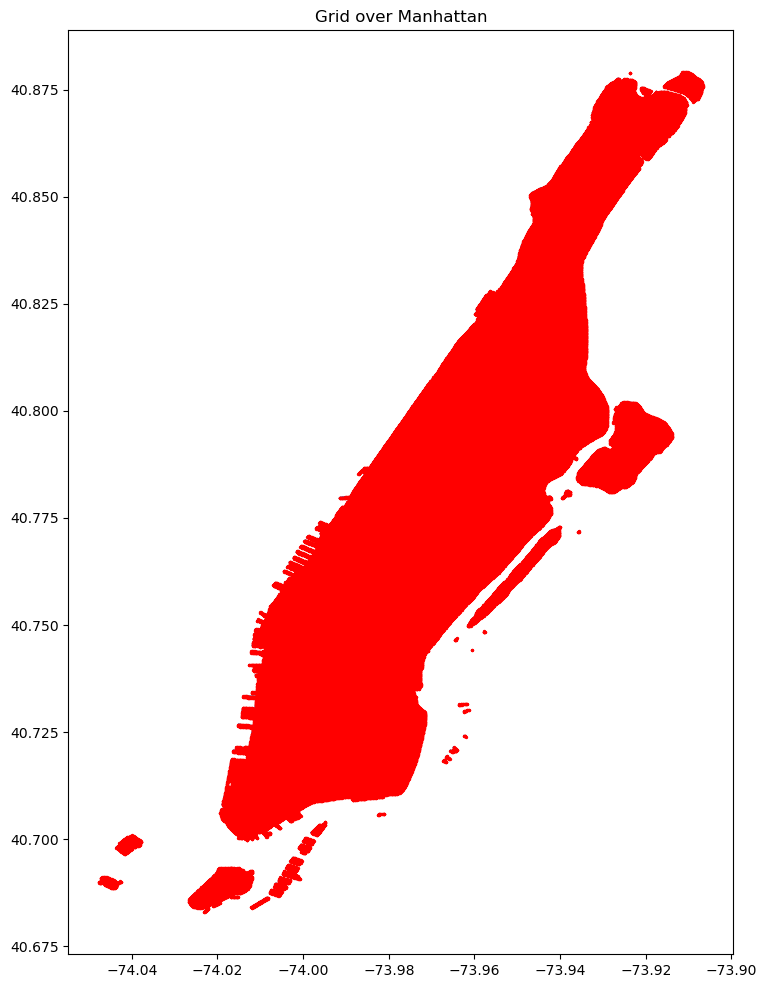

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
manhattan_boundary.plot(ax=ax, color='whitesmoke', edgecolor='black')

manhattan_grid.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.4)

manhattan_grid.centroid.plot(ax=ax, color='red', markersize=2)

ax.set_title("Grid over Manhattan")
plt.show()